<a href="https://colab.research.google.com/github/ruoheng-du/human-bot-account/blob/main/AML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/AML Final Project/twitter_human_bots_dataset.csv'

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [ ]:
# load dataset
df = pd.read_csv(dataset_path, index_col=0)

In [ ]:
# preview dataset
df.head(5)

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [ ]:
# check shape
df.shape

(37438, 19)

In [ ]:
# dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37438 entries, 0 to 37437
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   created_at                    37438 non-null  object 
 1   default_profile               37438 non-null  bool   
 2   default_profile_image         37438 non-null  bool   
 3   description                   30181 non-null  object 
 4   favourites_count              37438 non-null  int64  
 5   followers_count               37438 non-null  int64  
 6   friends_count                 37438 non-null  int64  
 7   geo_enabled                   37438 non-null  bool   
 8   id                            37438 non-null  int64  
 9   lang                          29481 non-null  object 
 10  location                      37434 non-null  object 
 11  profile_background_image_url  32939 non-null  object 
 12  profile_image_url             37437 non-null  object 
 13  screen

In [ ]:
# check target account_type
df['account_type'].value_counts(normalize=True)

,proportion
account_type,
human,0.668109
bot,0.331891


# Data Cleaning

## Drop non-informative columns



In [ ]:
# drop unneccesary columns
df = df.drop(columns=['created_at', 'profile_background_image_url', 'profile_image_url', 'id', 'screen_name'])
df.columns

Index(['default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'lang', 'location', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type'],
      dtype='object')

1. **`created_at`**: Dropped because `account_age_days` already captures the account's age, making this column redundant.
2. **`profile_background_image_url`**: Dropped because `default_profile` already indicates whether the account uses a default background, making the URL unnecessary.
3. **`profile_image_url`**: Dropped because `default_profile_image` already indicates whether the account uses a default profile image, so the URL adds no extra value.
4. **`id`**: Dropped because it's just a unique identifier with no predictive value for classifying human vs. bot.
5. **`screen_name`**: Dropped because it is a username chosen by the user and doesn't provide meaningful information for classification.

## Handle missing values

In [ ]:
# check missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

description    7257
lang           7957
location          4
dtype: int64


In [ ]:
# 'location' column
df = df.dropna(subset=['location'])
print(df.isnull().sum()[df.isnull().sum() > 0])

description    7256
lang           7955
dtype: int64


**`Location`**: Removed the rows with missing values since only 4 entries were affected. Given the minimal impact on the dataset, removing these rows simplifies the data without significant loss.

In [ ]:
# 'lang' column
# distribution of languages
lang_account_type_distribution = pd.crosstab(df['lang'], df['account_type'], normalize='index')
lang_account_type_distribution['total_count'] = df['lang'].value_counts()
print(lang_account_type_distribution)

account_type       bot     human  total_count
lang                                         
af            0.642643  0.357357          333
ar            0.636364  0.363636          594
bg            0.250000  0.750000           20
ca            0.222222  0.777778          198
cs            0.166667  0.833333           12
cy            0.447552  0.552448          143
da            0.235632  0.764368          174
de            0.233209  0.766791          536
el            0.500000  0.500000           18
en            0.244172  0.755828        21448
es            0.236603  0.763397         1213
et            0.294737  0.705263           95
fa            0.666667  0.333333           12
fi            0.388889  0.611111           72
fr            0.277333  0.722667          375
he            0.000000  1.000000            2
hi            0.375000  0.625000            8
hr            0.260000  0.740000           50
hu            0.085714  0.914286           35
id            0.309904  0.690096  

In [ ]:
# 'lang' column
# distribution of unknown languages
missing_lang_df = df[df['lang'].isnull()]
missing_lang_account_type_distribution = missing_lang_df['account_type'].value_counts(normalize=True)
print(missing_lang_account_type_distribution)

account_type
bot      0.564802
human    0.435198
Name: proportion, dtype: float64


In [ ]:
# 'lang' column
df['lang'] = df['lang'].fillna('Unknown')
print(df.isnull().sum()[df.isnull().sum() > 0])

description    7256
dtype: int64


**`Lang`**: Filled the missing values with `'Unknown'`. This decision was informed by the previous analysis, which showed that accounts with missing `lang` data had a slightly higher proportion of bots (56.5%) compared to humans (43.5%). Therefore, treating missing language information as a distinct category allows the model to learn from this pattern and preserves potentially useful information for classification.

In [ ]:
# 'description' column
# distribution with or without description
has_description_distribution = pd.crosstab(df['description'].notnull(), df['account_type'], normalize='index')
print(has_description_distribution)

account_type       bot     human
description                     
False         0.598953  0.401047
True          0.267678  0.732322


In [ ]:
# 'description' column
df['default_description'] = df['description'].notnull().astype(int)
df = df.drop(columns=['description'])
col = df.pop('default_description')
df.insert(0, 'default_description', col)
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


**`Description`**: Replaced the `description` column with `default_description`, indicating whether a description exists. The distribution analysis revealed that a significant proportion of accounts without a description tend to be bots (59.9% bots vs 40.1% humans), while accounts with a description are more likely to be human (73.2% humans vs 26.8% bots). This transformation simplifies the dataset while retaining the strong predictive signal that the presence or absence of a description provides for classification.

In [ ]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37434 entries, 0 to 37437
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   default_description     37434 non-null  int64  
 1   default_profile         37434 non-null  bool   
 2   default_profile_image   37434 non-null  bool   
 3   favourites_count        37434 non-null  int64  
 4   followers_count         37434 non-null  int64  
 5   friends_count           37434 non-null  int64  
 6   geo_enabled             37434 non-null  bool   
 7   lang                    37434 non-null  object 
 8   location                37434 non-null  object 
 9   statuses_count          37434 non-null  int64  
 10  verified                37434 non-null  bool   
 11  average_tweets_per_day  37434 non-null  float64
 12  account_age_days        37434 non-null  int64  
 13  account_type            37434 non-null  object 
dtypes: bool(4), float64(1), int64(6), object(3)

## Handle boolean columns

In [ ]:
# bool to int
bool_columns = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
df[bool_columns] = df[bool_columns].astype(int)

In [ ]:
# review dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37434 entries, 0 to 37437
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   default_description     37434 non-null  int64  
 1   default_profile         37434 non-null  int64  
 2   default_profile_image   37434 non-null  int64  
 3   favourites_count        37434 non-null  int64  
 4   followers_count         37434 non-null  int64  
 5   friends_count           37434 non-null  int64  
 6   geo_enabled             37434 non-null  int64  
 7   lang                    37434 non-null  object 
 8   location                37434 non-null  object 
 9   statuses_count          37434 non-null  int64  
 10  verified                37434 non-null  int64  
 11  average_tweets_per_day  37434 non-null  float64
 12  account_age_days        37434 non-null  int64  
 13  account_type            37434 non-null  object 
dtypes: float64(1), int64(10), object(3)
memory 

In [ ]:
# check shape
df.shape

(37434, 14)

# Exploratory Data Analysis

In [ ]:
# overview
df.head(5)

,default_description,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,1,0,0,4,1589,4,0,en,unknown,11041,0,7.870,1403,bot
1,1,0,0,536,860,880,0,en,Estados Unidos,252,0,0.183,1379,human
2,1,0,0,3307,172,594,1,en,"Los Angeles, CA",1001,0,0.864,1159,human
3,1,1,0,8433,517,633,1,en,"Birmingham, AL",1324,0,0.889,1489,human
4,1,0,0,88,753678,116,1,en,"England, United Kingdom",4202,1,1.339,3138,human


In [ ]:
# overview
df.describe()

,default_description,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,average_tweets_per_day,account_age_days
count,37434.000000,37434.000000,37434.000000,37434.000000,3.743400e+04,3.743400e+04,37434.000000,3.743400e+04,37434.000000,37434.000000,37434.000000
mean,0.806166,0.419886,0.014906,12301.007159,3.702405e+05,4.446382e+03,0.456163,2.107484e+04,0.201688,6.892210,3022.034995
std,0.395306,0.493547,0.121179,33923.164176,2.470885e+06,4.954783e+04,0.498081,6.733315e+04,0.401266,24.581361,1013.702984
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,483.000000
25%,1.000000,0.000000,0.000000,362.000000,3.500000e+01,3.700000e+01,0.000000,1.336250e+03,0.000000,0.495000,2316.000000
50%,1.000000,0.000000,0.000000,2066.000000,3.650000e+02,2.960000e+02,0.000000,4.209000e+03,0.000000,1.488000,3219.000000
75%,1.000000,1.000000,0.000000,8879.000000,8.440250e+03,8.930000e+02,1.000000,1.715375e+04,0.000000,5.528000,3888.000000
max,1.000000,1.000000,1.000000,885123.000000,1.216415e+08,4.343060e+06,1.000000,2.771910e+06,1.000000,1269.055000,5158.000000


## Numerical features

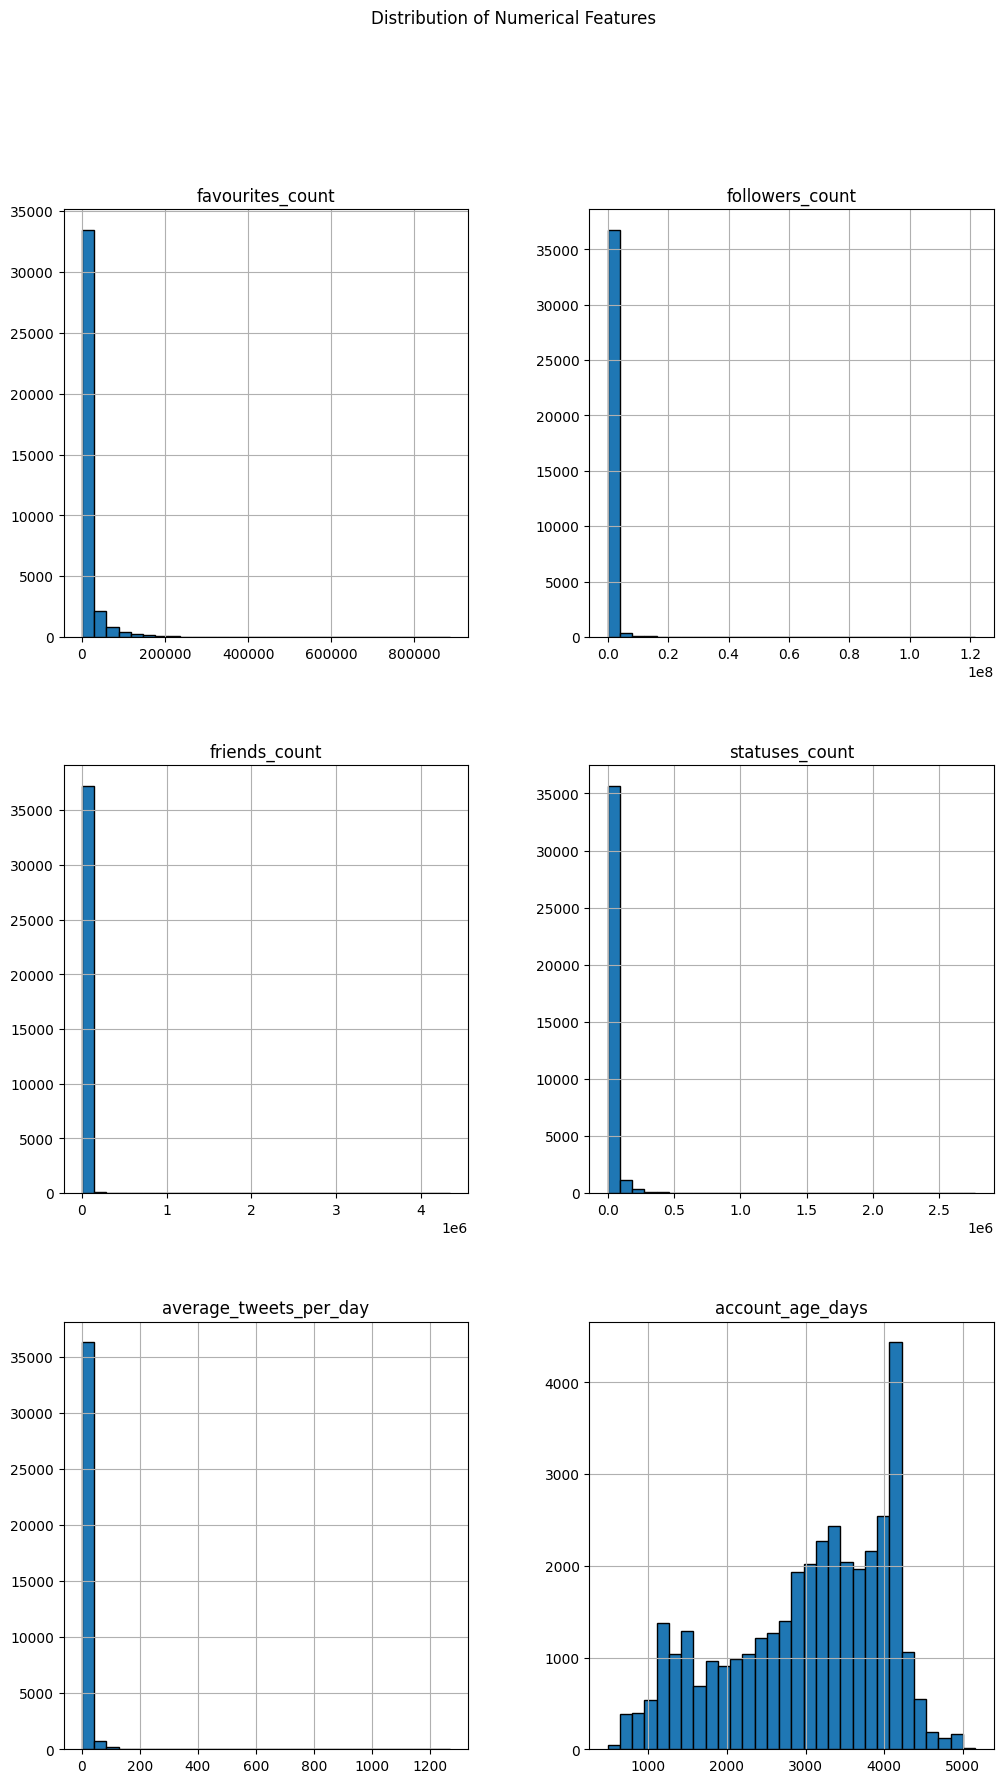

In [ ]:
# numerical features
num_features = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'average_tweets_per_day', 'account_age_days']
df[num_features].hist(figsize=(12, 20), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

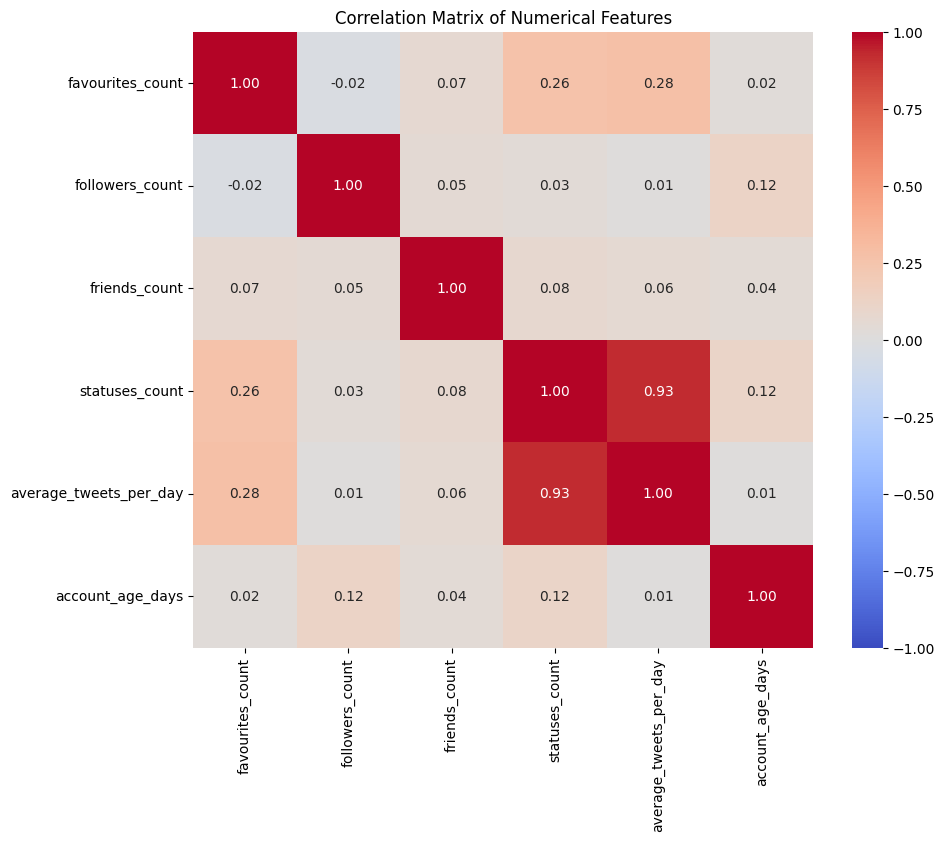

In [ ]:
# numerical features
corr_matrix = df[num_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# numerical features
# deal with multicollinearity/high_corr
df = df.drop(columns=['statuses_count'])

The `statuses_count` column is removed due to its high correlation with `average_tweets_per_day` column, keeping only the latter to avoid multicollinearity.

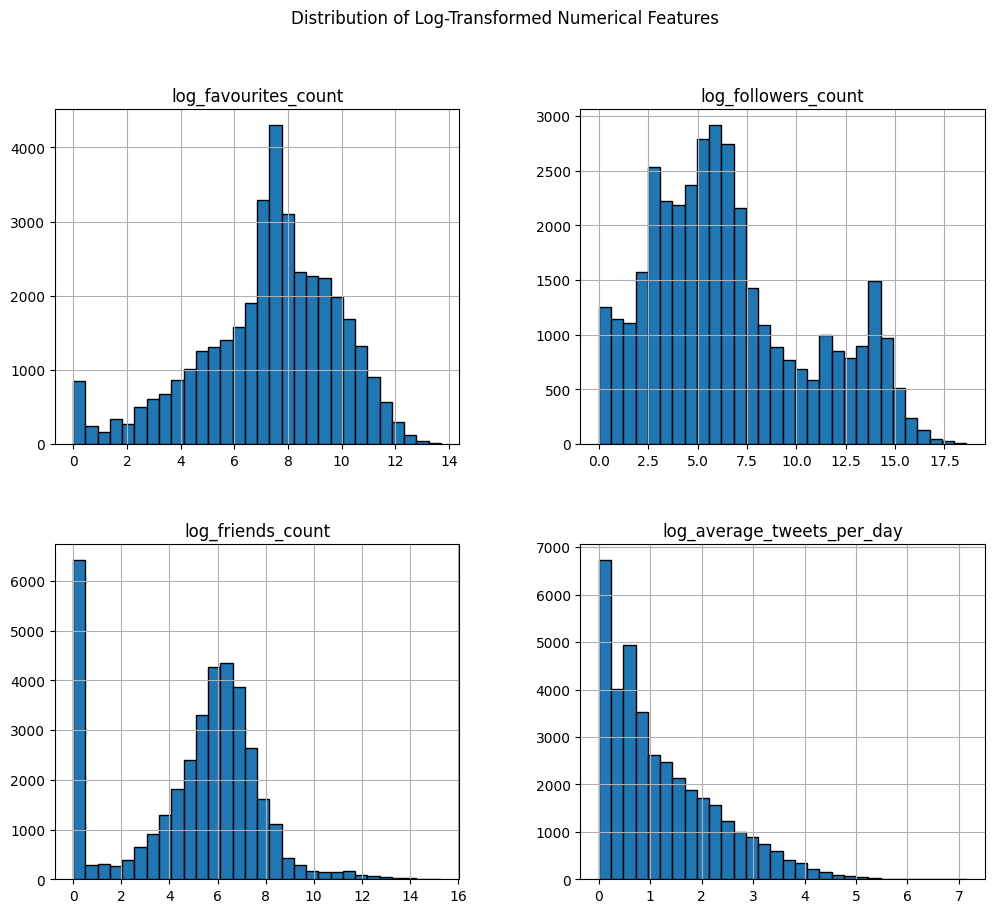

In [ ]:
# numerical features
# deal with long right tail
df['log_favourites_count'] = np.log1p(df['favourites_count'])
df['log_followers_count'] = np.log1p(df['followers_count'])
df['log_friends_count'] = np.log1p(df['friends_count'])
df['log_average_tweets_per_day'] = np.log1p(df['average_tweets_per_day'])

df[['log_favourites_count', 'log_followers_count', 'log_friends_count', 'log_average_tweets_per_day']].hist(
    figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Log-Transformed Numerical Features')
plt.show()

In [ ]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37434 entries, 0 to 37437
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   default_description         37434 non-null  int64  
 1   default_profile             37434 non-null  int64  
 2   default_profile_image       37434 non-null  int64  
 3   favourites_count            37434 non-null  int64  
 4   followers_count             37434 non-null  int64  
 5   friends_count               37434 non-null  int64  
 6   geo_enabled                 37434 non-null  int64  
 7   lang                        37434 non-null  object 
 8   location                    37434 non-null  object 
 9   verified                    37434 non-null  int64  
 10  average_tweets_per_day      37434 non-null  float64
 11  account_age_days            37434 non-null  int64  
 12  account_type                37434 non-null  object 
 13  log_favourites_count        37434 no

## Boolean features

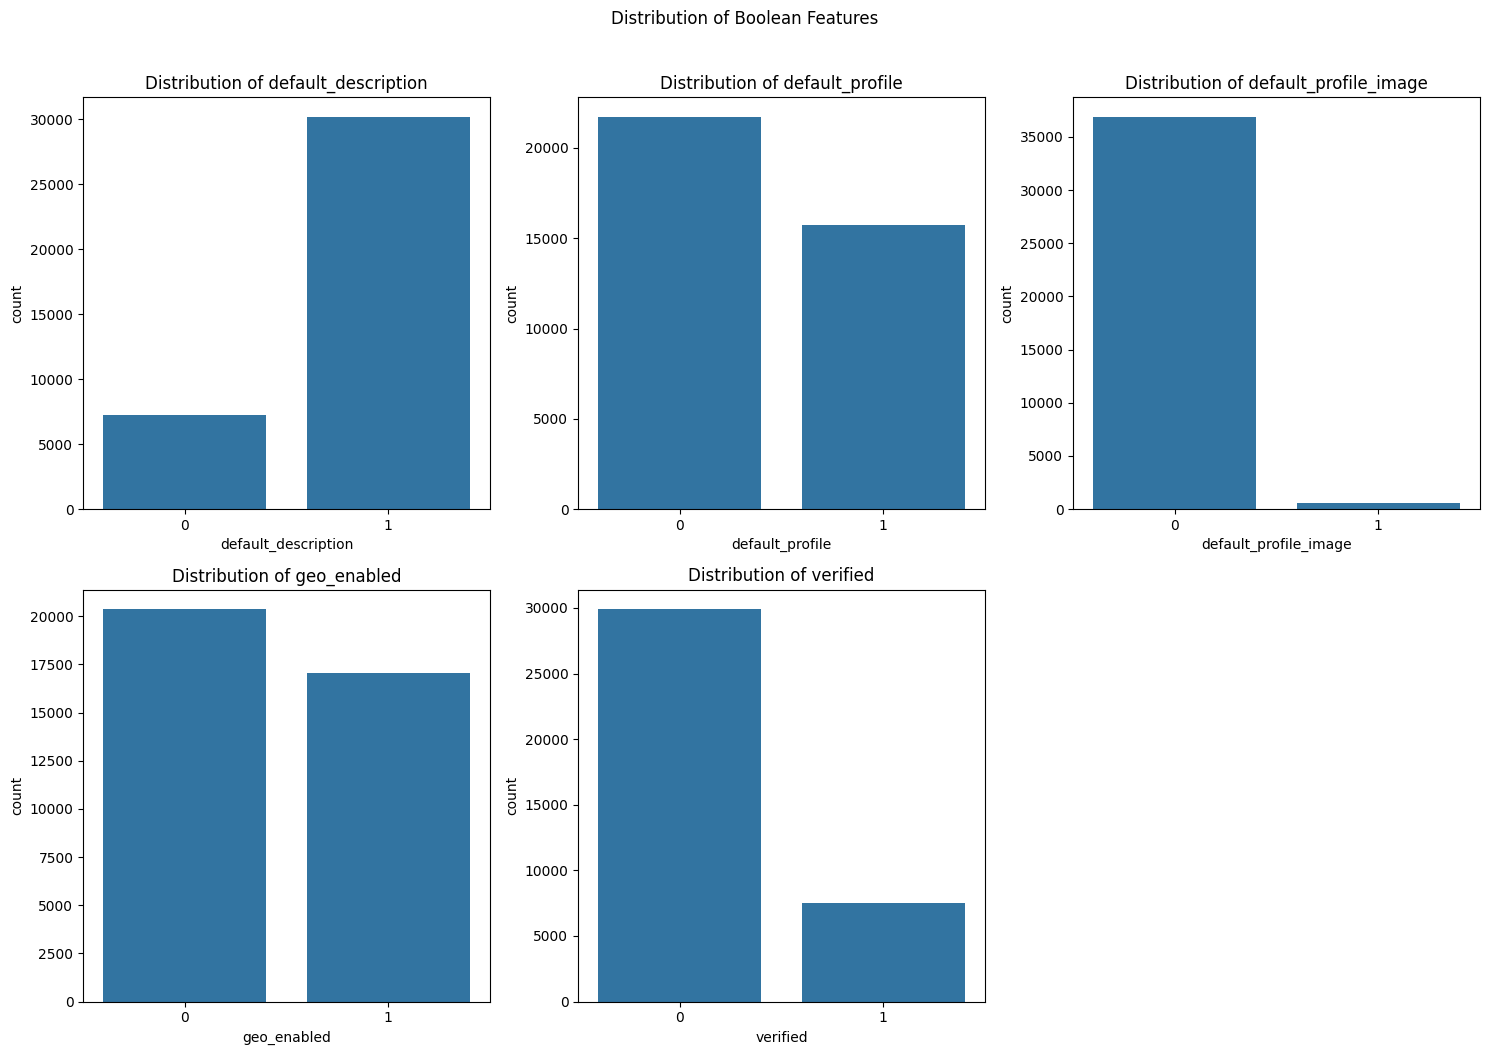

In [ ]:
# boolean features
bool_features = ['default_description', 'default_profile', 'default_profile_image', 'geo_enabled', 'verified']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(bool_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.suptitle('Distribution of Boolean Features', y=1.05)
plt.show()

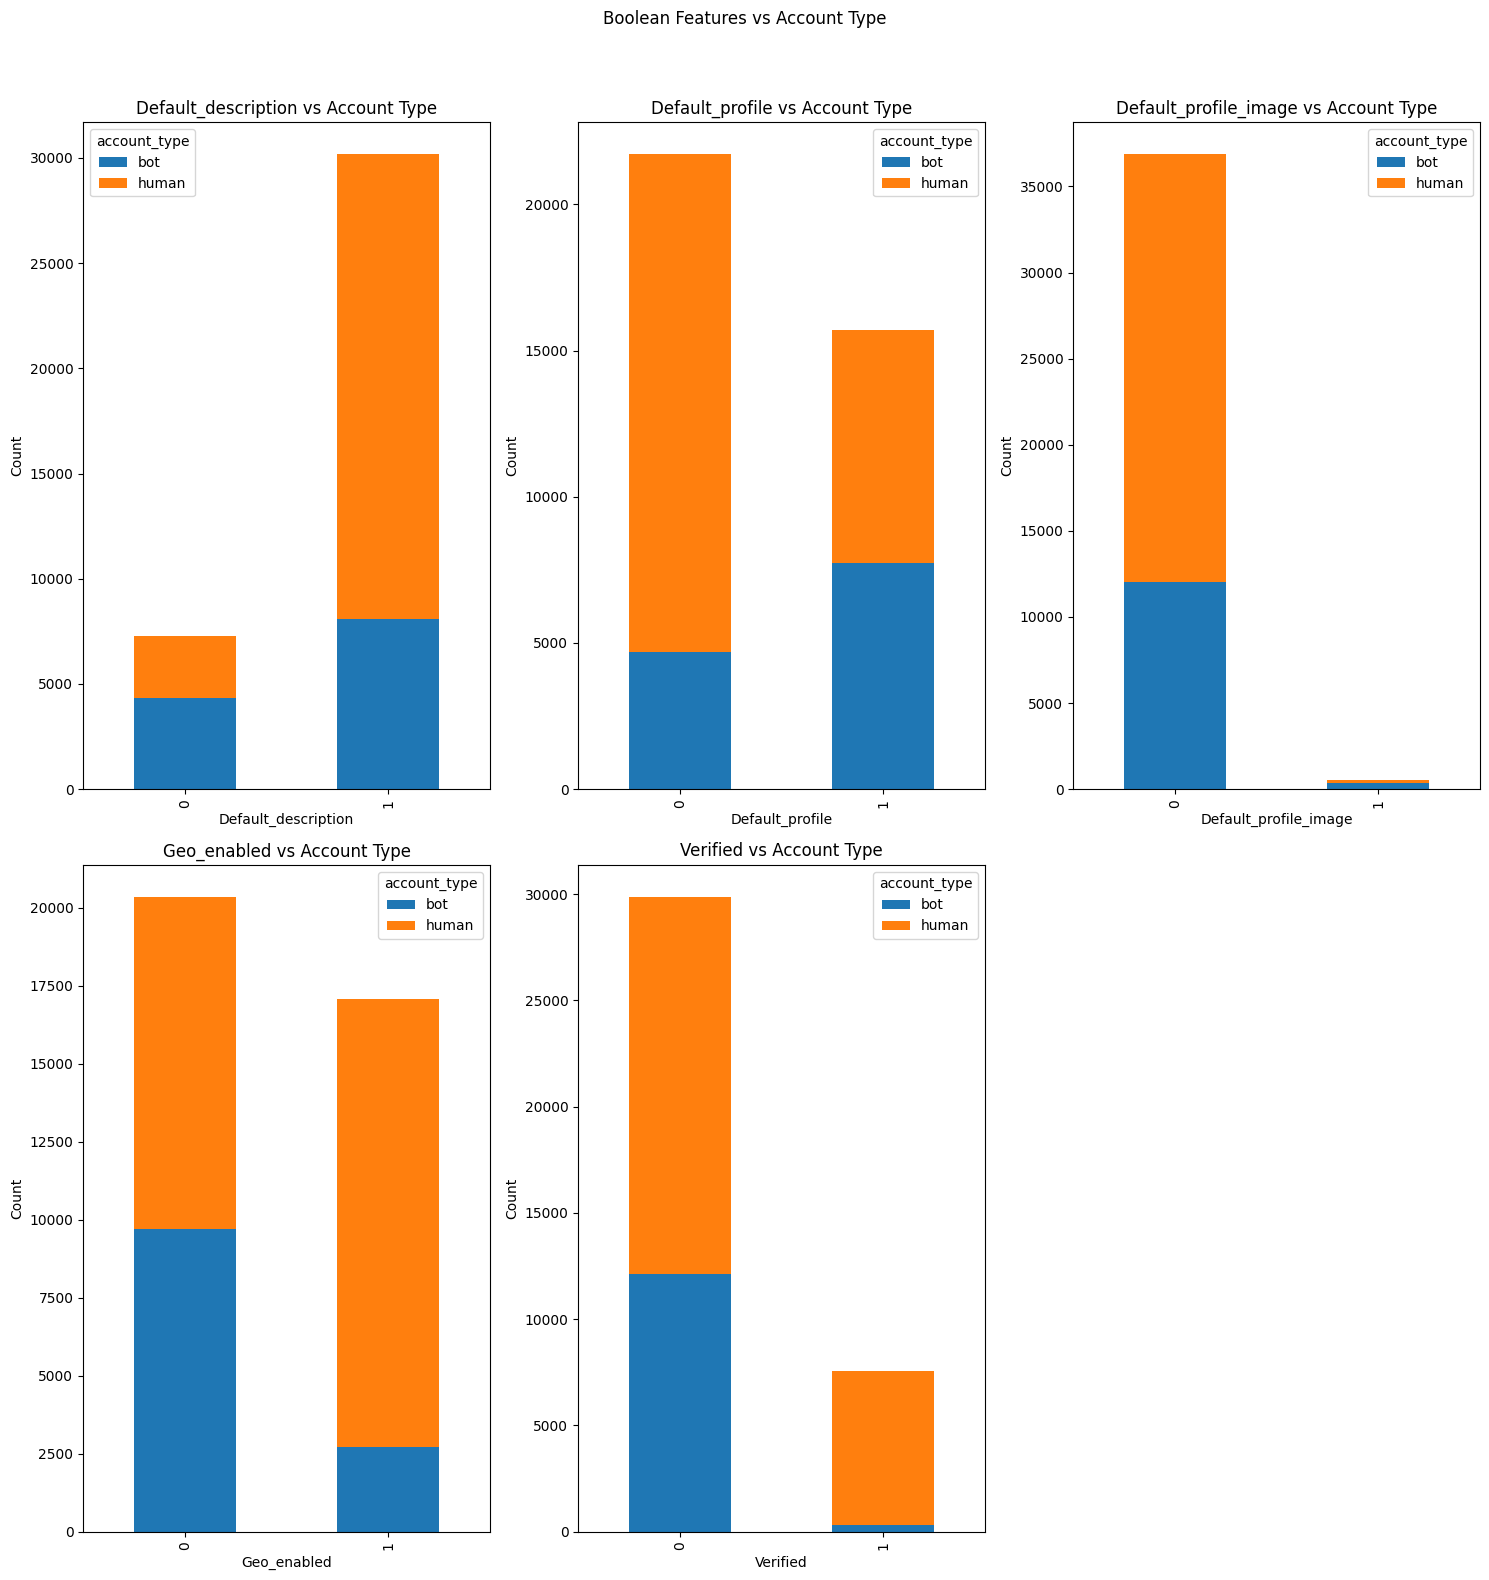

In [ ]:
# boolean features
plt.figure(figsize=(15, 15))
for i, feature in enumerate(bool_features, 1):
    plt.subplot(2, 3, i)
    pd.crosstab(df[feature], df['account_type']).plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'{feature.capitalize()} vs Account Type')
    plt.xlabel(f'{feature.capitalize()}')
    plt.ylabel('Count')
plt.tight_layout()
plt.suptitle('Boolean Features vs Account Type', y=1.05)
plt.show()

In [ ]:
# boolean features
from scipy.stats import chi2_contingency

for feature in bool_features:
    contingency_table = pd.crosstab(df[feature], df['account_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {feature}:")
    print(f"Chi2 Statistic = {chi2}, p-value = {p}\n")

Chi-Square Test for default_description:
Chi2 Statistic = 2893.5419264761026, p-value = 0.0

Chi-Square Test for default_profile:
Chi2 Statistic = 3147.9370719994035, p-value = 0.0

Chi-Square Test for default_profile_image:
Chi2 Statistic = 319.39011572127094, p-value = 1.966743077902374e-71

Chi-Square Test for geo_enabled:
Chi2 Statistic = 4228.649111946962, p-value = 0.0

Chi-Square Test for verified:
Chi2 Statistic = 3586.2348566076143, p-value = 0.0



In [ ]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37434 entries, 0 to 37437
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   default_description         37434 non-null  int64  
 1   default_profile             37434 non-null  int64  
 2   default_profile_image       37434 non-null  int64  
 3   favourites_count            37434 non-null  int64  
 4   followers_count             37434 non-null  int64  
 5   friends_count               37434 non-null  int64  
 6   geo_enabled                 37434 non-null  int64  
 7   lang                        37434 non-null  object 
 8   location                    37434 non-null  object 
 9   verified                    37434 non-null  int64  
 10  average_tweets_per_day      37434 non-null  float64
 11  account_age_days            37434 non-null  int64  
 12  account_type                37434 non-null  object 
 13  log_favourites_count        37434 no

## Categorical features

In [ ]:
# categorical features
# unique lang
lang_unique_count = df['lang'].nunique()
lang_unique_count

49

In [ ]:
# categorical features
# unique location
location_unique_count = df['location'].nunique()
location_unique_count

12049

In [ ]:
# categorical features
# total instances of rare locations
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts < 5]
rare_locations.sum()

13179

In [ ]:
# categorical features
# deal with rare locations
df['location'] = df['location'].apply(lambda x: 'Other' if x in rare_locations.index else x)

Since Target Encoding assigns a value to each category based on the target variable's mean within that category, categories with a small number of instances are heavily influenced by individual data points, making the encoded values unreliable. Grouping rare locations into `'Other'` prevents overfitting in Target Encoding by reducing noise from categories with too few instances.

In [ ]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37434 entries, 0 to 37437
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   default_description         37434 non-null  int64  
 1   default_profile             37434 non-null  int64  
 2   default_profile_image       37434 non-null  int64  
 3   favourites_count            37434 non-null  int64  
 4   followers_count             37434 non-null  int64  
 5   friends_count               37434 non-null  int64  
 6   geo_enabled                 37434 non-null  int64  
 7   lang                        37434 non-null  object 
 8   location                    37434 non-null  object 
 9   verified                    37434 non-null  int64  
 10  average_tweets_per_day      37434 non-null  float64
 11  account_age_days            37434 non-null  int64  
 12  account_type                37434 non-null  object 
 13  log_favourites_count        37434 no

## Target variable

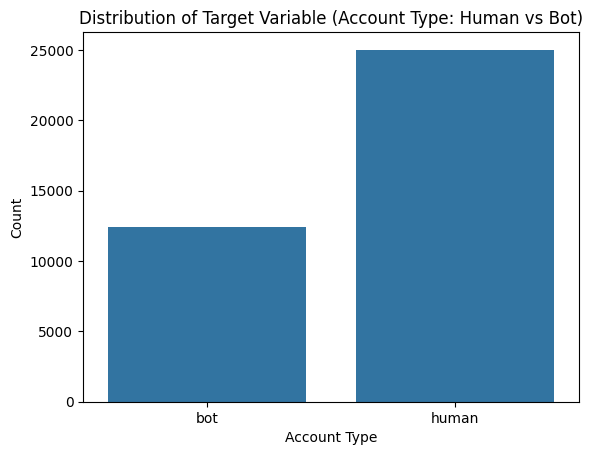

In [ ]:
# visualize target distribution
sns.countplot(x='account_type', data=df)
plt.title('Distribution of Target Variable (Account Type: Human vs Bot)')
plt.xlabel('Account Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# map target variable
df['account_type'] = df['account_type'].map({'human': 0, 'bot': 1})

In [ ]:
# check dataset
df.head(5)

,default_description,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,lang,location,verified,average_tweets_per_day,account_age_days,account_type,log_favourites_count,log_followers_count,log_friends_count,log_average_tweets_per_day
0,1,0,0,4,1589,4,0,en,unknown,0,7.870,1403,1,1.609438,7.371489,1.609438,2.182675
1,1,0,0,536,860,880,0,en,Estados Unidos,0,0.183,1379,0,6.285998,6.758095,6.781058,0.168054
2,1,0,0,3307,172,594,1,en,"Los Angeles, CA",0,0.864,1159,0,8.104099,5.153292,6.388561,0.622725
3,1,1,0,8433,517,633,1,en,"Birmingham, AL",0,0.889,1489,0,9.040026,6.249975,6.452049,0.636048
4,1,0,0,88,753678,116,1,en,"England, United Kingdom",1,1.339,3138,0,4.488636,13.532722,4.762174,0.849723


# Data Preprocessing

## Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split

features = ['log_favourites_count', 'log_followers_count', 'log_friends_count', 'log_average_tweets_per_day', 'account_age_days',
            'default_description', 'default_profile', 'default_profile_image', 'geo_enabled', 'verified', 'lang', 'location']

target = 'account_type'

X = df[features]
y = df[target]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,
                                                  random_state=42, stratify=y_train_val)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (22460, 12)
Shape of X_val: (7487, 12)
Shape of X_test: (7487, 12)
Shape of y_train: (22460,)
Shape of y_val: (7487,)
Shape of y_test: (7487,)


## Numerical features: Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['log_favourites_count', 'log_followers_count',
                      'log_friends_count', 'log_average_tweets_per_day', 'account_age_days']

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

## Categorical features: Encoding

In [ ]:
from category_encoders import TargetEncoder

categorical_features = ['lang', 'location']

target_encoder = TargetEncoder(cols=categorical_features)
X_train[categorical_features] = target_encoder.fit_transform(X_train[categorical_features], y_train)
X_val[categorical_features] = target_encoder.transform(X_val[categorical_features])
X_test[categorical_features] = target_encoder.transform(X_test[categorical_features])

# t-SNE Visualization

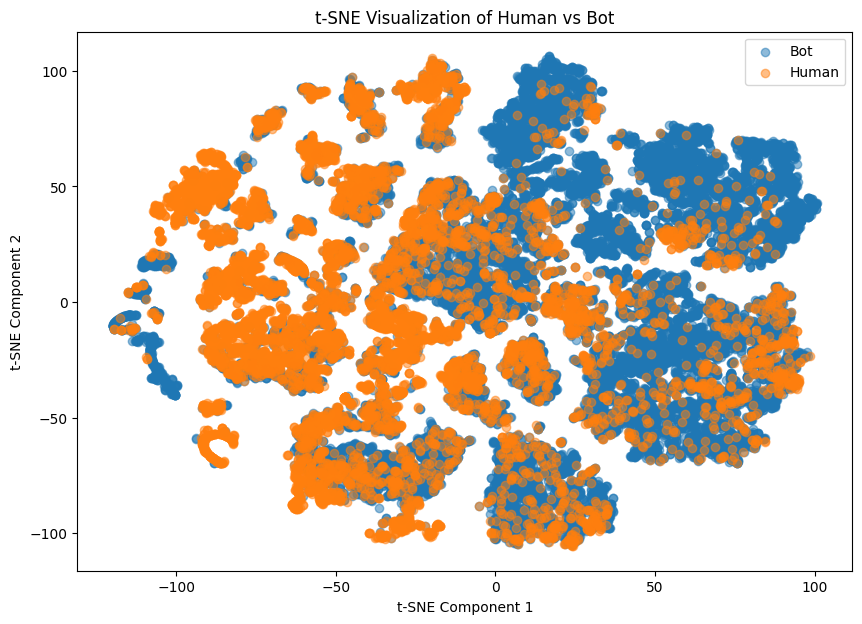

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X_train_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 7))
plt.scatter(X_train_tsne[y_train == 0, 0], X_train_tsne[y_train == 0, 1], label='Bot', alpha=0.5)
plt.scatter(X_train_tsne[y_train == 1, 0], X_train_tsne[y_train == 1, 1], label='Human', alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Human vs Bot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Download Data

In [ ]:
# X
X_train.to_csv('/content/drive/My Drive/AML Final Project/X_train.csv', index = False)
X_val.to_csv('/content/drive/My Drive/AML Final Project/X_val.csv', index = False)
X_test.to_csv('/content/drive/My Drive/AML Final Project/X_test.csv', index = False)
# y
y_train.to_csv('/content/drive/My Drive/AML Final Project/y_train.csv', index = False)
y_val.to_csv('/content/drive/My Drive/AML Final Project/y_val.csv', index = False)
y_test.to_csv('/content/drive/My Drive/AML Final Project/y_test.csv', index = False)

# Models

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

## Baseline: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)

y_pred_logreg_train = logreg.predict(X_train)
y_pred_logreg_test = logreg.predict(X_test)

logreg_train_acc = accuracy_score(y_train, y_pred_logreg_train)
logreg_test_acc = accuracy_score(y_test, y_pred_logreg_test)
logreg_f1_train = f1_score(y_train, y_pred_logreg_train)
logreg_f1_test = f1_score(y_test, y_pred_logreg_test)

print(f"Logistic Regression Train Accuracy: {logreg_train_acc:.4f}")
print(f"Logistic Regression Test Accuracy: {logreg_test_acc:.4f}")
print(f"Logistic Regression Train F1 Score: {logreg_f1_train:.4f}")
print(f"Logistic Regression Test F1 Score: {logreg_f1_test:.4f}")

Logistic Regression Train Accuracy: 0.8023
Logistic Regression Test Accuracy: 0.8006
Logistic Regression Train F1 Score: 0.6839
Logistic Regression Test F1 Score: 0.6819


## SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(X_train, y_train)

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

svm_train_acc = accuracy_score(y_train, y_pred_svm_train)
svm_test_acc = accuracy_score(y_test, y_pred_svm_test)
svm_f1_train = f1_score(y_train, y_pred_svm_train)
svm_f1_test = f1_score(y_test, y_pred_svm_test)

print(f"SVM Train Accuracy: {svm_train_acc:.4f}")
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")
print(f"SVM Train F1 Score: {svm_f1_train:.4f}")
print(f"SVM Test F1 Score: {svm_f1_test:.4f}")

SVM Train Accuracy: 0.8611
SVM Test Accuracy: 0.8553
SVM Train F1 Score: 0.7760
SVM Test F1 Score: 0.7677


## Tree-based

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

rf_train_acc = accuracy_score(y_train, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf_test)
rf_f1_train = f1_score(y_train, y_pred_rf_train)
rf_f1_test = f1_score(y_test, y_pred_rf_test)

print(f"Random Forest Train Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")
print(f"Random Forest Train F1 Score: {rf_f1_train:.4f}")
print(f"Random Forest Test F1 Score: {rf_f1_test:.4f}")

Random Forest Train Accuracy: 1.0000
Random Forest Test Accuracy: 0.8783
Random Forest Train F1 Score: 1.0000
Random Forest Test F1 Score: 0.8054


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

y_pred_ada_train = ada.predict(X_train)
y_pred_ada_test = ada.predict(X_test)

ada_train_acc = accuracy_score(y_train, y_pred_ada_train)
ada_test_acc = accuracy_score(y_test, y_pred_ada_test)
ada_f1_train = f1_score(y_train, y_pred_ada_train)
ada_f1_test = f1_score(y_test, y_pred_ada_test)

print(f"AdaBoost Train Accuracy: {ada_train_acc:.4f}")
print(f"AdaBoost Test Accuracy: {ada_test_acc:.4f}")
print(f"AdaBoost Train F1 Score: {ada_f1_train:.4f}")
print(f"AdaBoost Test F1 Score: {ada_f1_test:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Train Accuracy: 0.8411
AdaBoost Test Accuracy: 0.8372
AdaBoost Train F1 Score: 0.7507
AdaBoost Test F1 Score: 0.7470


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb_train = xgb.predict(X_train)
y_pred_xgb_test = xgb.predict(X_test)

xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)
xgb_f1_train = f1_score(y_train, y_pred_xgb_train)
xgb_f1_test = f1_score(y_test, y_pred_xgb_test)

print(f"XGBoost Train Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")
print(f"XGBoost Train F1 Score: {xgb_f1_train:.4f}")
print(f"XGBoost Test F1 Score: {xgb_f1_test:.4f}")

XGBoost Train Accuracy: 0.9341
XGBoost Test Accuracy: 0.8782
XGBoost Train F1 Score: 0.8970
XGBoost Test F1 Score: 0.8076


## Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

nn_model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.fit(X_train_new, y_train_new, epochs=50, batch_size=128, validation_data=(X_val, y_val))

y_pred_nn_train = (nn_model.predict(X_train) > 0.5).astype("int32")
y_pred_nn_test = (nn_model.predict(X_test) > 0.5).astype("int32")

nn_train_loss, nn_train_acc = nn_model.evaluate(X_train, y_train, verbose=0)
nn_test_loss, nn_test_acc = nn_model.evaluate(X_test, y_test, verbose=0)
nn_f1_train = f1_score(y_train, y_pred_nn_train)
nn_f1_test = f1_score(y_test, y_pred_nn_test)

print(f"Neural Network Train Accuracy: {nn_train_acc:.4f}")
print(f"Neural Network Test Accuracy: {nn_test_acc:.4f}")
print(f"Neural Network Train F1 Score: {nn_f1_train:.4f}")
print(f"Neural Network Test F1 Score: {nn_f1_test:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7451 - loss: 0.5140 - val_accuracy: 0.8396 - val_loss: 0.3702
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8373 - loss: 0.3706 - val_accuracy: 0.8457 - val_loss: 0.3509
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8522 - loss: 0.3476 - val_accuracy: 0.8573 - val_loss: 0.3410
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8554 - loss: 0.3417 - val_accuracy: 0.8593 - val_loss: 0.3354
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8613 - loss: 0.3306 - val_accuracy: 0.8603 - val_loss: 0.3311
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8593 - loss: 0.3309 - val_accuracy: 0.8606 - val_loss: 0.3260
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8617 - loss: 0.3237 - val_accuracy: 0.8628 - val_loss: 0.3254
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8645 - loss: 0.3214 - val_accuracy: 0.8576 - val_